In [20]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pyvis.network import Network
import numpy as np
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd

In [3]:
# Wczytujemy wcześniej utworzoną tabelę
df = pd.read_hdf('./outputs/budzety_clean.h5')

In [4]:
# Zapisujemy nazwy budżetów do zmiennej 'sentence_list'
sentence_list = df['names'].tolist()
miasta = df['miasto'].tolist()

In [5]:
# Nazwa modelu to tworzenia embeddingów ze zdań
model_name ="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" 

In [6]:
# Tworzymy model. Jeżeli nie mamy go zapisanego na dysku, to zostanie ściągnięty
# Ograniczamy ilość słów w zdaniu do 512
model = SentenceTransformer(model_name)
model.max_seq_length = 512

In [7]:
# Tworzymy embeddingi z 'sentence_list'
embedding = model.encode(sentence_list, convert_to_tensor=True)

In [8]:
# Liczymy odległość cosinusową między wektorami - każdy z każdym
cosine_scores = util.pytorch_cos_sim(embedding, embedding)

In [ ]:
# Iterujemy po 'cosine_scores' i wybieramy te wartości, które są największe.
# Przypominam: 'cosine_scores' zawiera miary cosinusowe każdego wektora z każdym
# Dwa wektory są do siebie podobne, jeżeli kąt między nimi jest najmniejszy, tzn.
# cosinus kąta między nimi jest największy (najbardziej zbliżony do 1)
# Dlatego szukamy wartości maksymalnej.
count = 0
similar_names = []
similar_city = []
for scores in tqdm(cosine_scores):
    scores[count] = 0
    max_elements, max_indices = torch.max(scores, dim=0)
    max_index = max_indices.item()
    print('==='*30)
    print(count)
    print(df.iloc[count]['nazwa'])
    print(df.iloc[max_index]['nazwa'])

    similar_names.append(df.iloc[max_index]['nazwa'])
    similar_city.append(df.iloc[max_index]['miasto'])

    count +=1


In [10]:
# Zapisujemy znalezione podobne budżety oraz odpowiadające im miasta do tabeli
df['similar'] = similar_names
df['city_of_similar'] = similar_city

In [152]:
df[['rok', 'miasto', 'nazwa', 'similar', 'city_of_similar']]
# Tabela zawiera nazwy budżetów najbardziej podobne (kolumna 'similar') do danego 
# budżetu (z kolumny 'nazwa') oraz miasto, z którego pochodzi budżet z kolumny 'similar'

,rok,miasto,nazwa,similar,city_of_similar
0,2020,GDYNIA,Projektistatus,Projekty duze,GDYNIA
1,2020,GDYNIA,Doposażenie parku pomiędzy Estakadą Kwiatkowsk...,Solankowe Tychy – budowa tężni parkowej przy u...,TYCHY
2,2020,GDYNIA,Cykliczne warsztaty dla seniorów z dzielnicy O...,Cykliczne warsztaty dla seniorów z dzielnicy O...,GDYNIA
3,2020,GDYNIA,"Ogród Sąsiedzki przy Dzikim Sadzie, ul. Źródlana",Dziki Ogród Spoteczny,GDAŃSK
4,2020,GDYNIA,Montaż słupów oświetleniowych na chodniku przy...,Wykonanie oświetlonego przejścia między ul. Dę...,GDAŃSK
...,...,...,...,...,...
23687,2020,KRAKÓW,Zielony skwer na Zabtociu,Zielony skwer na Zabłociu,KRAKÓW
23688,2020,KRAKÓW,Znani Biatopradniczanie dla Mieszkanców,Znani Białoprądniczanie dla Mieszkańców,KRAKÓW
23690,2020,KRAKÓW,ZRÓBMY SKWER PRZY FABRYCZNEJ! Edukacja i kultu...,Zróbmy skwer przy Fabrycznej! Edukacja i kultu...,KRAKÓW
23691,2020,KRAKÓW,Zróbmy sobie Park,Zróbmy sobie Park,KRAKÓW


In [164]:
# Zapisujemy utworzoną tabelę do pliku
df[['rok', 'miasto', 'nazwa', 'similar', 'city_of_similar']].to_hdf('./outputs/similar_names.h5', key='df')

In [165]:
# Tworzymy nową tabelę z samymi parami miasto-miasto
new_df = df[['miasto', 'city_of_similar']]
new_df

,miasto,city_of_similar
0,GDYNIA,GDYNIA
1,GDYNIA,TYCHY
2,GDYNIA,GDYNIA
3,GDYNIA,GDAŃSK
4,GDYNIA,GDAŃSK
...,...,...
23687,KRAKÓW,KRAKÓW
23688,KRAKÓW,KRAKÓW
23690,KRAKÓW,KRAKÓW
23691,KRAKÓW,KRAKÓW


In [166]:
# Radom nie występuje w 'city_of_similar' - nie ma budżetów podobnych do innych
# miast. Trochę to psuje ogólną strukturę par, więc zasadniczo niewielkim
# błędem będzie jak dodamy jedną relację Radom-Radom, żeby Radom
# pojawił się w 'city_of_similar'
radom = {'miasto':'RADOM', 'city_of_similar':'RADOM'}
new_df = new_df.append(radom, ignore_index=True)

In [167]:
new_df

,miasto,city_of_similar
0,GDYNIA,GDYNIA
1,GDYNIA,TYCHY
2,GDYNIA,GDYNIA
3,GDYNIA,GDAŃSK
4,GDYNIA,GDAŃSK
...,...,...
23026,KRAKÓW,KRAKÓW
23027,KRAKÓW,KRAKÓW
23028,KRAKÓW,KRAKÓW
23029,KRAKÓW,KRAKÓW


In [192]:
# W ilu przypadkach dane miasto wskazuje na samo siebie, tzn. w ilu przypadkach
# podobne tematy nie wykraczają poza dane miasto
summary_df = pd.get_dummies(new_df['city_of_similar']).groupby(new_df['miasto']).apply(sum)

summary_df

,BIAŁA PODLASKA,BIAŁYSTOK,BIELSKO-BIAŁA,BYDGOSZCZ,BYTOM,CHEŁM,CHORZÓW,CZĘSTOCHOWA,DĄBROWA GÓRNICZA,ELBLĄG,...,WROCŁAW,WŁOCŁAWEK,ZABRZE,ZAMOŚĆ,ZIELONA GÓRA,ŁOMŻA,ŁÓDŹ,ŚWINOUJŚCIE,ŚWIĘTOCHŁOWICE,ŻORY
miasto,,,,,,,,,,,,,,,,,,,,,
BIAŁA PODLASKA,9,0,0,5,0,1,1,1,1,0,...,1,0,0,0,1,0,4,0,1,0
BIAŁYSTOK,1,111,5,6,3,0,1,2,2,2,...,4,2,3,0,0,0,21,1,0,0
BIELSKO-BIAŁA,0,3,29,6,0,2,1,3,0,3,...,3,1,0,0,0,1,16,0,0,0
BYDGOSZCZ,4,8,5,164,0,4,4,12,10,6,...,15,7,2,3,2,5,88,0,1,0
BYTOM,0,2,1,1,25,3,1,0,2,2,...,2,0,1,1,0,0,13,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ŁOMŻA,0,0,2,4,0,1,1,3,2,2,...,1,0,1,0,0,13,11,0,0,0
ŁÓDŹ,4,21,9,84,3,15,7,30,28,14,...,57,8,17,3,9,5,1978,4,1,2
ŚWINOUJŚCIE,0,1,2,1,0,0,0,2,1,0,...,0,0,1,0,0,0,6,5,0,0


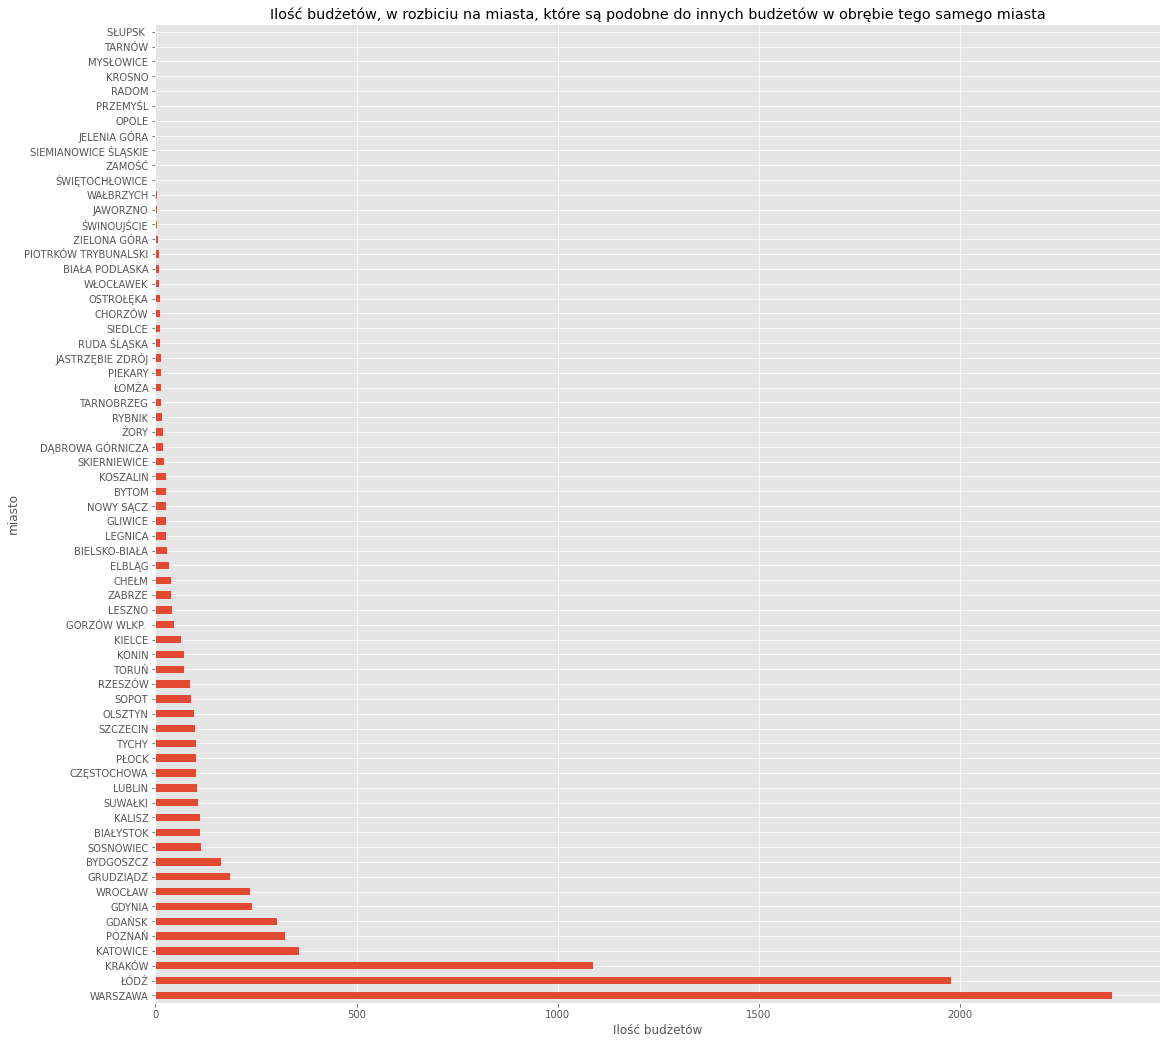

In [195]:
plt.figure(figsize=(18,18))
plt.title('Ilość budżetów, w rozbiciu na miasta, które są podobne do innych budżetów w obrębie tego samego miasta')
plt.style.use('ggplot')
plt.xlabel('Ilość budżetów')
pd.Series(np.diag(summary_df), index=summary_df.index).sort_values(ascending=False).plot(kind='barh');

In [168]:
# Poniższe kroki mają na celu przygotowanie danych do utworzenia grafu

# Ile mamy unikalnych połączeń (kolumna 'weight')
grouped = new_df.groupby(['miasto', 'city_of_similar']).size().reset_index().rename(columns={0:'weight'})
grouped

,miasto,city_of_similar,weight
0,BIAŁA PODLASKA,BIAŁA PODLASKA,9
1,BIAŁA PODLASKA,BYDGOSZCZ,5
2,BIAŁA PODLASKA,CHEŁM,1
3,BIAŁA PODLASKA,CHORZÓW,1
4,BIAŁA PODLASKA,CZĘSTOCHOWA,1
...,...,...,...
2388,ŻORY,TORUŃ,2
2389,ŻORY,TYCHY,1
2390,ŻORY,WARSZAWA,4
2391,ŻORY,ŁÓDŹ,6


In [169]:
# Tym poleceniem usuwamy miasta, które są podobne do samych siebie, 
# Można to zasadniczo zwizualizować na grafie (w postaci pętli wokół tego samego
# węzła), ale staje się to nieczytelne. Zakładamy, że interesują nas tylko
# relacje z innymi miastami, nie z tym samym miastem. 
grouped = grouped[grouped['miasto'] != grouped['city_of_similar']]

In [181]:
SCALING_FACTOR = 10 # Skalowanie grubości linii. Im bliższa 1, tym krawędzi będą
# grubsze i przez to mniej czytelne. Grubość linii zależy od wagi połączenia - im
# większa waga, tym grubsza linia, ale wprowadziłem dodatkowo ten parametr, 
# żeby zeskalować w dół te grubości, żebyśmy zyskali na czytelności

MORE_THEN = 21 # Minimalna ilość relacji, jakie chcemy zobaczyć
# Jeżeli pokazywalibyśmy wszystkie relacje (MORE_THEN = 1), wówczas wszystkie
# węzły byłyby z sobą połączone. Zależy nam na pokazywaniu tylko tych krawędzi, 
# gdzie ilość połączeń jest większa niż wskazujemy.

In [182]:
# Zastosowanie zmiennej MORE_THEN
grouped_less = grouped[grouped['weight']> MORE_THEN]

len(grouped_less) # Będzie ostatecznie tyle krawędzi

108

In [183]:
# Tworzymy węzły jako połączenie dwóch słowników - miasto może występować w 'miasto'
# ale może nie występować w 'city_of_similar', dlatego łączymy te dwa słowniki
# żeby uniknąć tego problemu
nodes = list(set(grouped_less['miasto'].unique().tolist()) | set(grouped_less['city_of_similar'].unique().tolist()))
nodes

['KONIN',
 'ELBLĄG',
 'SOPOT',
 'PŁOCK',
 'SOSNOWIEC',
 'BIAŁYSTOK',
 'OLSZTYN',
 'WARSZAWA',
 'WROCŁAW',
 'GRUDZIĄDZ',
 'DĄBROWA GÓRNICZA',
 'POZNAŃ',
 'TYCHY',
 'LUBLIN',
 'TORUŃ',
 'BIELSKO-BIAŁA',
 'NOWY SĄCZ',
 'KATOWICE',
 'CZĘSTOCHOWA',
 'BYDGOSZCZ',
 'SZCZECIN',
 'RZESZÓW',
 'KIELCE',
 'KALISZ',
 'GDAŃSK',
 'GDYNIA',
 'GORZÓW WLKP. ',
 'GLIWICE',
 'ŁÓDŹ',
 'KRAKÓW']

In [190]:
# Zastosowanie zmiennej SCALING_FACTOR
grouped_less['weight'] = grouped_less['weight'] / SCALING_FACTOR

C:\Users\mariu\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
# Tworzymy krawędzie
edges = list(zip(grouped_less.miasto, grouped_less.city_of_similar, grouped_less.weight))

In [196]:
# Opcje przekazane jako tekst do pyvis
options = """{
  "nodes": {
    "color": {
      "border": "rgba(112,46,233,1)"
    }
  },
  "edges": {
    "arrows": {
      "middle": {
        "enabled": true,
        "scaleFactor": 0.3
      }
    },
    "arrowStrikethrough": false,
    "color": {
      "color": "rgba(190,188,201,0.61)",
      "highlight": "rgba(53,178,90,1)",
      "hover": "rgba(38,40,132,1)",
      "inherit": false
    },
    "shadow": {
      "enabled": true
    },
    "smooth": false
  },
  "interaction": {
    "hover": true
  },
  "physics": {
    "minVelocity": 0.75,
    "solver": "repulsion"
  }
}
"""

In [201]:
# Utworzenie grafu
# Jeżeli chcesz pominąć powyższe opcje i pokombinować w ręczne ustawienie
# właściwości węzłów i krawędzi, tzn. kolorów, interakcję itp... to zakomentuj
# linię oznaczoną jako A i odkomentuj linię B

net = Network('1000px', '1000px')
net.set_options(options) # A
# net.show_buttons(filter_=True) # B
net.add_nodes(nodes)
net.add_edges(edges)
net.show('./outputs/city_graph.html') # zamknij okno przeglądarki, które się otworzy
# Nie są wykrywane ścieżki względne, ale plik html się utworzył, więc otwórz
# go z katalogu outputs